In [1]:
libraries<-c("WGCNA","ggplot2", "reshape2", "ComplexHeatmap","pheatmap","dplyr","textshape","tidyr")
suppressPackageStartupMessages(lapply(libraries, require, character.only = TRUE))

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

In [2]:
 cpucores <- 32
  require(parallel)
  options("mc.cores"=cpucores)

  #Set CPU cores for doParallel-related functions
  require(doParallel)
  cores <- makeCluster(detectCores(), type='PSOCK')
  registerDoParallel(cores)

Loading required package: parallel

Loading required package: doParallel

Loading required package: foreach

Loading required package: iterators



In [6]:
allowWGCNAThreads(32)
enableWGCNAThreads(nThreads = 32)

disableWGCNAThreads()

WGCNAnThreads()

Allowing multi-threading with up to 32 threads.
Allowing parallel execution with up to 32 working processes.


[1] 1

In [7]:
load("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA/WGCNA_Lbraziliensis.RData")


In [2]:
#cargar los datos normalizados (TMM) 
tmm_norm<- read.delim("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/05_DEG/normCounts_tmm.tsv",header = T)

In [3]:
#cargar metadata
sample_metadata = read.delim("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/05_DEG/metadata.txt",
                      header=T)

In [2]:
# crear carpetas para datos output y setear directorio de trabajo 

path<-"/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA"
dir.create(paste0(path,"/plots"),recursive = TRUE,showWarnings = FALSE)
plots<-paste0(path,"/plots")

dir.create(paste0(path,"/tables"),recursive = TRUE,showWarnings = FALSE)
tables<-paste0(path,"/tables")
dir.create(paste0(tables,"/old_modules"),recursive = TRUE,showWarnings = FALSE)
dir.create(paste0(tables,"/new_modules"),recursive = TRUE,showWarnings = FALSE)

setwd(path)

In [3]:
# datos normalizados transformar con log2 y transponer matriz
datExpr = t(log2(tmm_norm+1))


In [4]:
# Calculate sample distance and cluster the samples
sampleTree = hclust(dist(datExpr), method = "ward.D2");

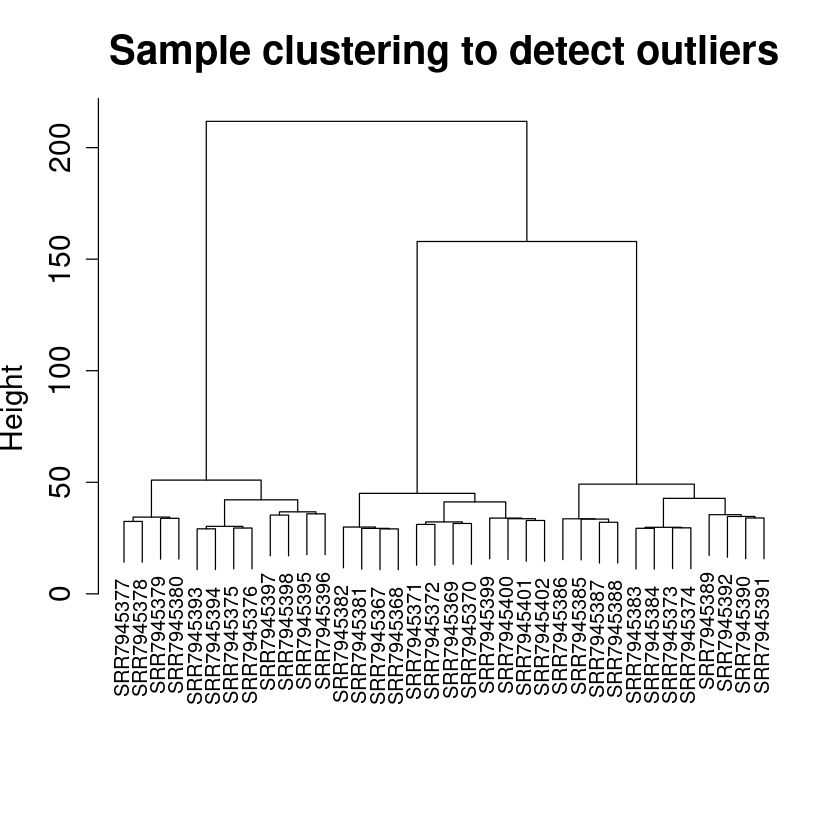

In [5]:
#plot sampleTree
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="",
     cex.lab = 1.5,cex.axis = 1.5, cex.main = 2)

In [6]:
#save sampleTree clustering 
pdf(file = paste0(plots,"/1-n-sampleClustering.pdf"), width = 40, height = 9);
par(cex = 1.3);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="",
     cex.lab = 1.5,cex.axis = 1.5, cex.main = 2)
dev.off()


pdf 
  2

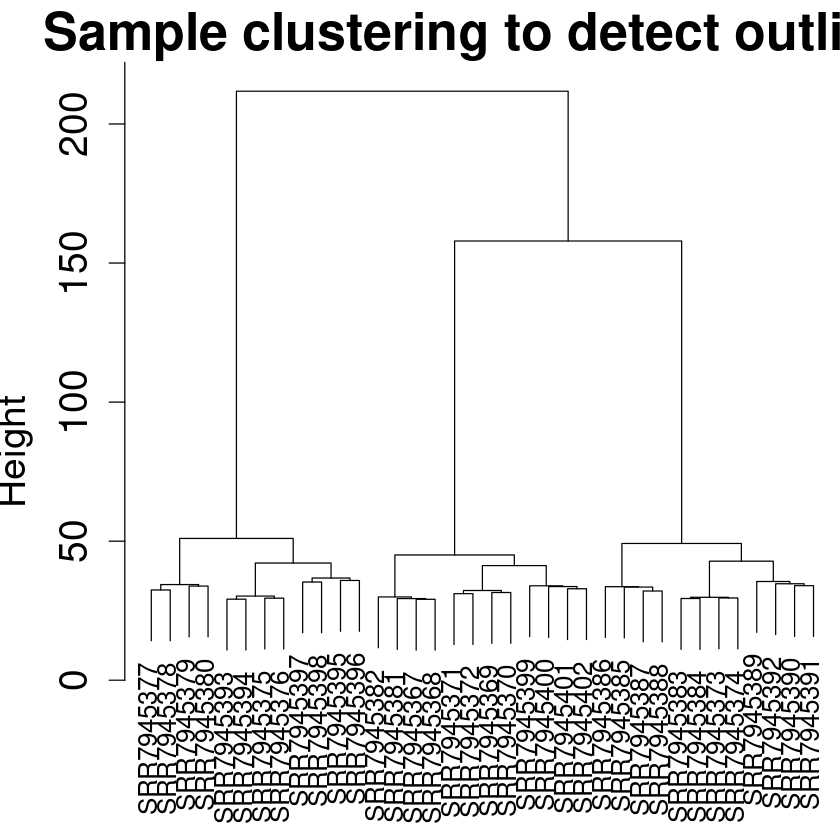

In [7]:
par(cex = 1.3);
par(mar = c(0,4,2,0))
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="",
     cex.lab = 1.5,cex.axis = 1.5, cex.main = 2)

In [8]:
# Choose a set of soft threshold parameters
powers = c(c(1:10), seq(from = 12, to=30, by=2))


In [8]:
sft = pickSoftThreshold(datExpr, powerVector = powers, verbose = 5,networkType = "unsigned",RsquaredCut = 0.80) 

pickSoftThreshold: will use block size 3225.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3225 of 13872
   ..working on genes 3226 through 6450 of 13872
   ..working on genes 6451 through 9675 of 13872
   ..working on genes 9676 through 12900 of 13872
   ..working on genes 12901 through 13872 of 13872
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.00206 -20.500          0.973  6940.0   6940.00   6990
2      2  0.62700  -1.660          0.557  4070.0   4030.00   4750
3      3  0.67600  -0.884          0.599  2630.0   2580.00   3660
4      4  0.70500  -0.748          0.646  1830.0   1760.00   3000
5      5  0.73400  -0.731          0.692  1340.0   1250.00   2560
6      6  0.75800  -0.745          0.727  1020.0    920.00   2230
7      7  0.76900  -0.772          0.749   803.0    691.00   1980
8      8  0.79000  -0.793          0.778   650.0    529.00   1780
9      9  0.78900  -0.822          0.785   536.0   

In [11]:
#save soft threshold table
write.table(sft$fitIndices,file = paste0(tables,"/sft_threshold_indices.tsv"),sep = '\t',quote = F)

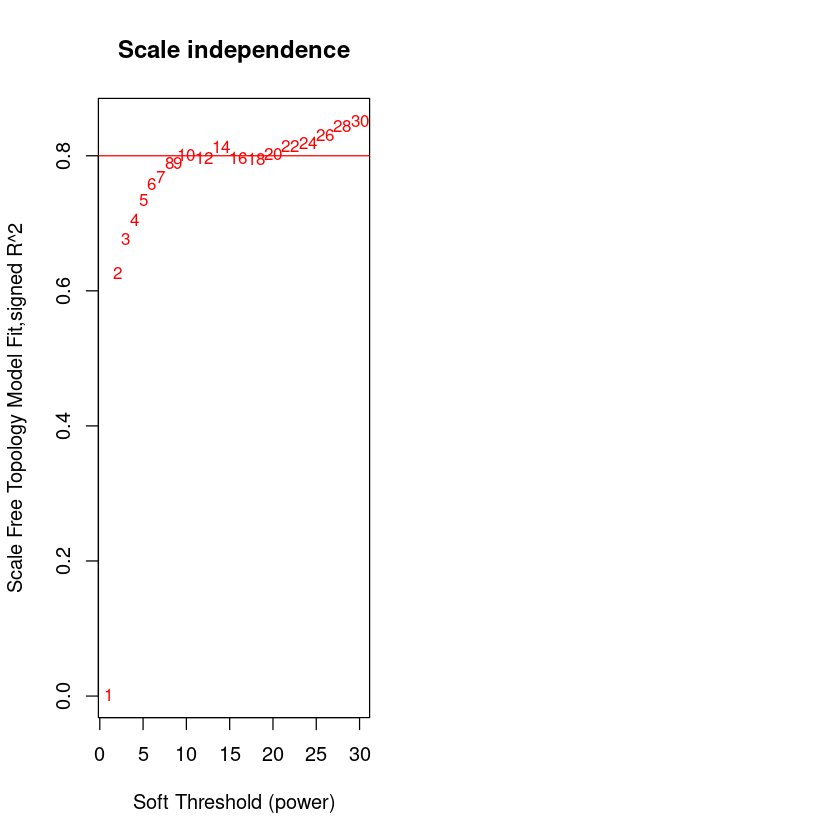

In [9]:
par(mfrow = c(1,2));
cex1 = .85;
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.80,col="red") 


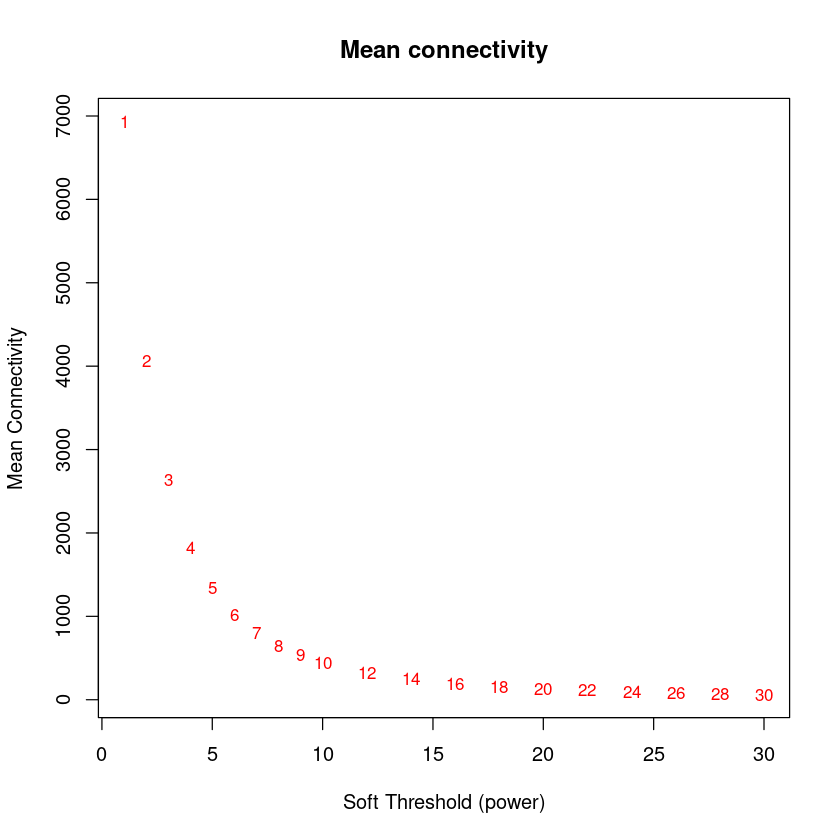

In [10]:
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity")) 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")


In [11]:
# Scale-free topology fit index as a function of the soft-thresholding power
pdf(file = paste0(plots,"/2-n-sft.pdf"), width = 9, height = 5);
par(mfrow = c(1,2));
cex1 = 0.9;
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red") 
# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity")) 
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")
dev.off()

pdf 
  2

In [12]:
sft

Power,SFT.R.sq,slope,truncated.R.sq,mean.k.,median.k.,max.k.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.002063422,-20.4722315,0.9728386,6935.93831,6936.134726,6986.4391
2,0.627129339,-1.6603742,0.5565220,4065.52173,4029.908215,4745.3714
3,0.676380172,-0.8841634,0.5989120,2631.07147,2577.262183,3660.4964
4,0.705248621,-0.7482703,0.6460881,1826.66653,1757.024438,3003.4174
5,0.733861106,-0.7307429,0.6922303,1337.11238,1250.157566,2556.6375
6,0.757900792,-0.7450184,0.7274451,1019.78467,919.541954,2229.5329
7,0.768711494,-0.7719992,0.7491390,803.40367,690.691943,1977.5808
8,0.789765535,-0.7930088,0.7777719,649.58521,529.399622,1776.2884
9,0.789389735,-0.8220095,0.7851620,536.38703,410.988630,1611.0127


In [13]:
# Turn data expression into topological overlap matrix
power=14 #12 se escoje de acuerdo a los parametros de sft


In [14]:
#  step-by-step adjacency matrix
TOM = TOMsimilarityFromExpr(datExpr, power = power,nThreads=32,networkType = "unsigned")
dissTOM = 1-TOM 
dim(dissTOM)

TOM calculation: adjacency..
..will use 32 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


[1] 13872 13872

In [15]:
head(TOM)

1.0000000,0.2101302,0.4064624,0.3719366,0.3186712,0.3304677,0.3811344,0.08343962,0.03375713,0.3551721,⋯,6.454274e-06,0.0097444520,1.623858e-04,0.0020261753,7.074827e-06,0.2145729,0.17976090,8.977279e-06,6.510574e-06,8.167856e-06
0.2101302,1.0000000,0.3903051,0.3453971,0.2482440,0.2109389,0.3482562,0.07412894,0.02650990,0.4043000,⋯,1.179511e-04,0.0004488868,1.111380e-05,0.0003574753,3.937770e-05,0.2154419,0.04965367,3.160201e-05,4.678355e-05,3.504523e-05
0.4064624,0.3903051,1.0000000,0.4409923,0.4286240,0.4063411,0.4410075,0.13397397,0.05116027,0.4347333,⋯,1.333060e-05,0.0029808994,1.680594e-05,0.0007745049,4.555417e-06,0.3892982,0.14706826,3.343881e-06,4.681641e-06,3.638020e-06
0.3719366,0.3453971,0.4409923,1.0000000,0.3905020,0.3729852,0.4034244,0.11894196,0.04635746,0.4187841,⋯,1.162683e-05,0.0031839489,2.209265e-05,0.0008150298,4.706394e-06,0.3447849,0.13774143,3.671933e-06,5.025751e-06,4.167282e-06
0.3186712,0.2482440,0.4286240,0.3905020,1.0000000,0.3203980,0.3985744,0.09272807,0.03694610,0.3921381,⋯,8.128486e-06,0.0052783827,6.570626e-05,0.0011282231,5.384285e-06,0.2489237,0.13996698,5.395148e-06,5.320873e-06,5.372139e-06
0.3304677,0.2109389,0.4063411,0.3729852,0.3203980,1.0000000,0.3816247,0.08104095,0.03554283,0.3546500,⋯,5.809428e-06,0.0101076924,1.719668e-04,0.0019089689,7.283035e-06,0.2131443,0.17732422,9.677205e-06,7.102390e-06,8.829224e-06


In [78]:
#  Construct modules
# Plot gene tree
geneTree = hclust(as.dist(dissTOM), method = "average")

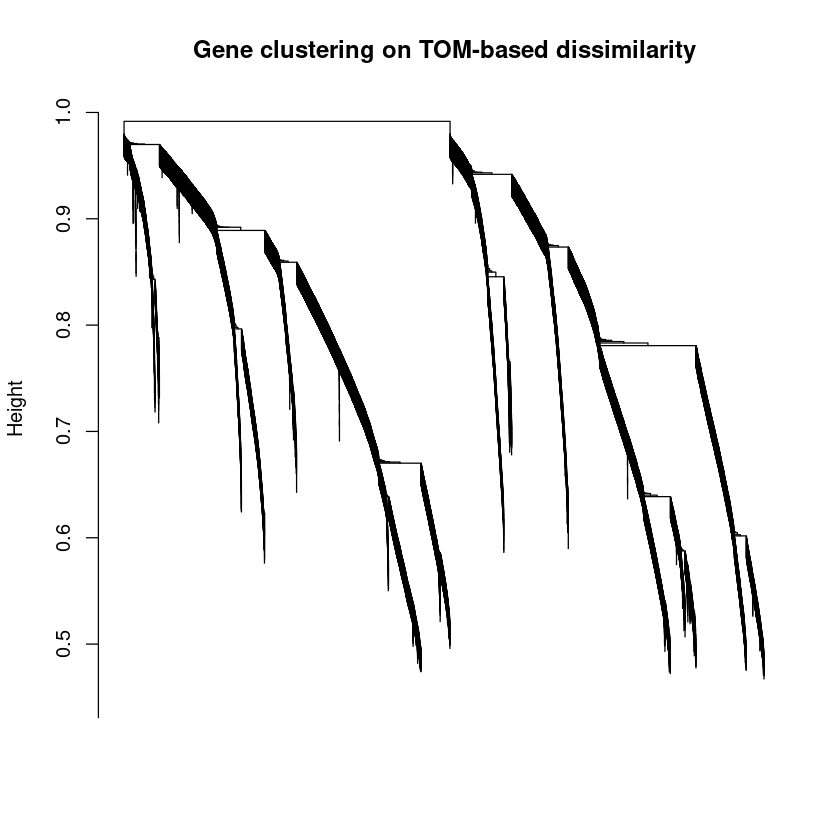

In [79]:
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04);

In [18]:
pdf(file = paste0(plots,"/3-gene_cluster.pdf"), width = 12, height = 9);
plot(geneTree, xlab="", sub="", main = "Gene clustering on TOM-based dissimilarity",
     labels = FALSE, hang = 0.04);
dev.off()


pdf 
  2

In [19]:
# Module identification using dynamic tree cut
# We like large modules, so we set the minimum module size relatively high:
# minModuleSize = 30;
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM,deepSplit = 2, 
                            pamRespectsDendro = FALSE,minClusterSize = 10);


 ..cutHeight not given, setting it to 0.987  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [20]:
table(dynamicMods)
length(table(dynamicMods)) 

dynamicMods
   1    2    3    4    5    6    7    8    9   10   11   12   13   14 
2834 2377 1813 1660 1252 1141  577  439  435  371  351  280  176  166 

[1] 14

In [21]:
# Convert numeric labels into colors
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

dynamicColors
      black        blue       brown        cyan       green greenyellow 
        577        2377        1813         166        1252         351 
    magenta        pink      purple         red      salmon         tan 
        435         439         371        1141         176         280 
  turquoise      yellow 
       2834        1660 

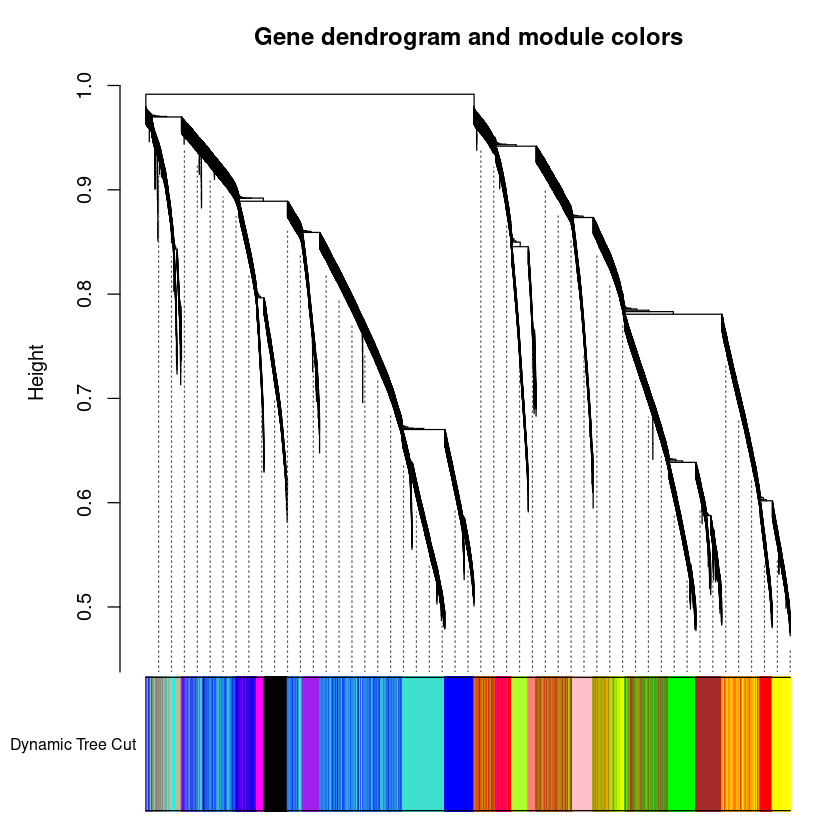

In [22]:
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",dendroLabels = FALSE,
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05,main = "Gene dendrogram and module colors")


In [23]:
#save module dendrogram
pdf(file =  paste0(plots,"/4-module_tree.pdf"), width = 8, height = 6);
plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut",dendroLabels = FALSE,
                    hang = 0.03,addGuide = TRUE, guideHang = 0.05,main = "Gene dendrogram and module colors")
dev.off()

pdf 
  2

In [24]:
#  Merge modules
# Calculate eigengenes
MEList = moduleEigengenes(datExpr, colors = dynamicColors)
MEs = MEList$eigengenes


In [25]:
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs)

In [26]:
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "ward.D2")

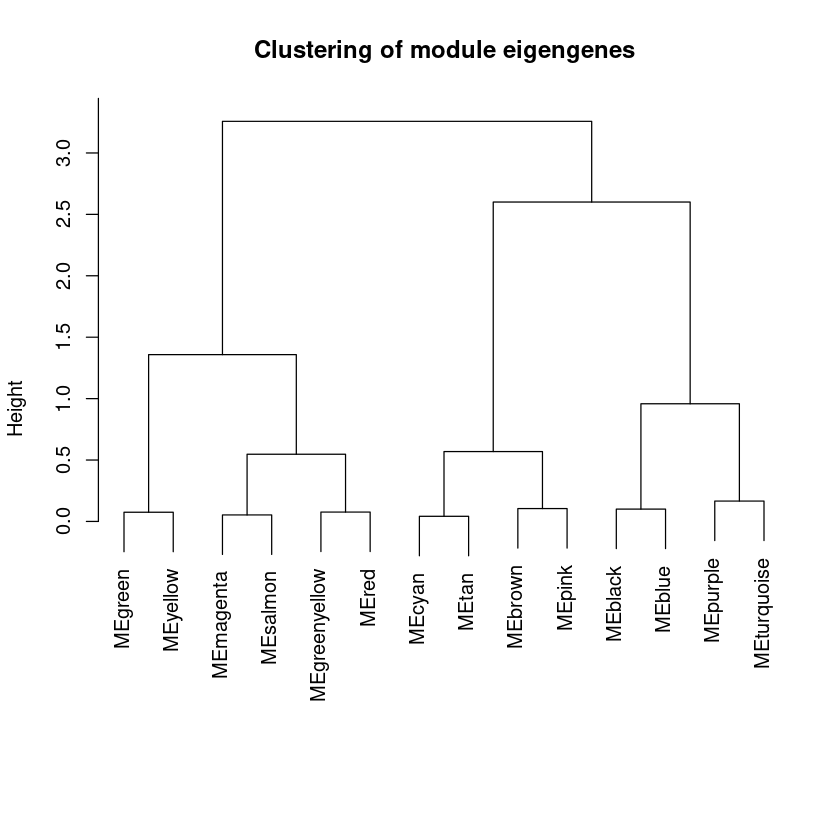

In [27]:
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")

 mergeCloseModules: Merging modules whose distance is less than 0.1
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 14 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


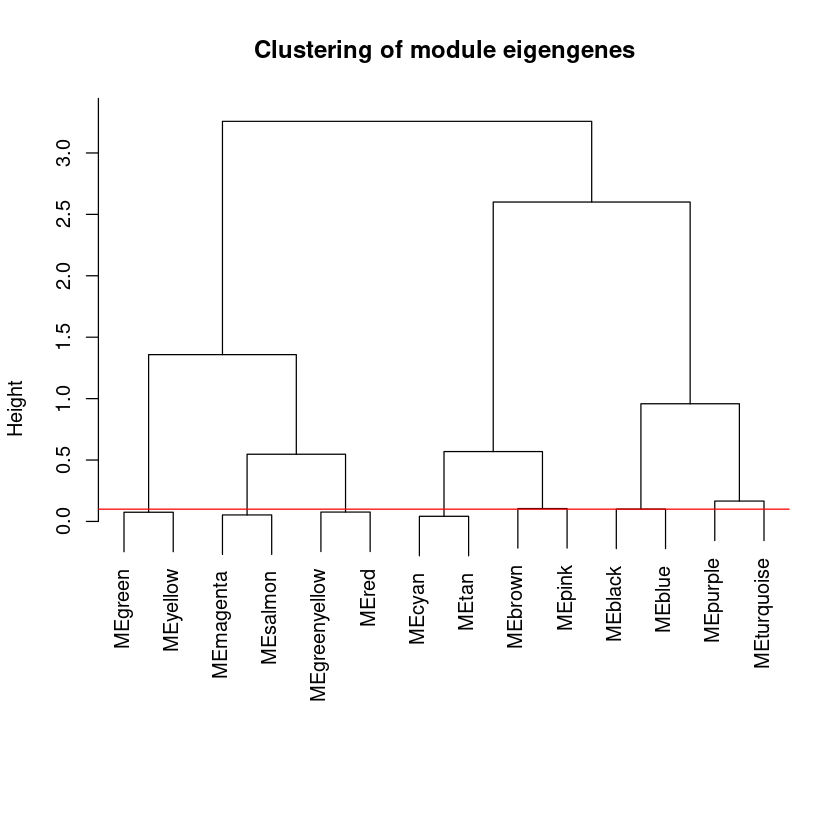

In [28]:
plot(METree, main = "Clustering of module eigengenes",
     xlab = "", sub = "")
# Merge close modules
MEDissThres=0.1
abline(h=MEDissThres, col = "red")
merge = mergeCloseModules(datExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3) 
mergedColors = merge$colors  
mergedMEs = merge$newMEs  

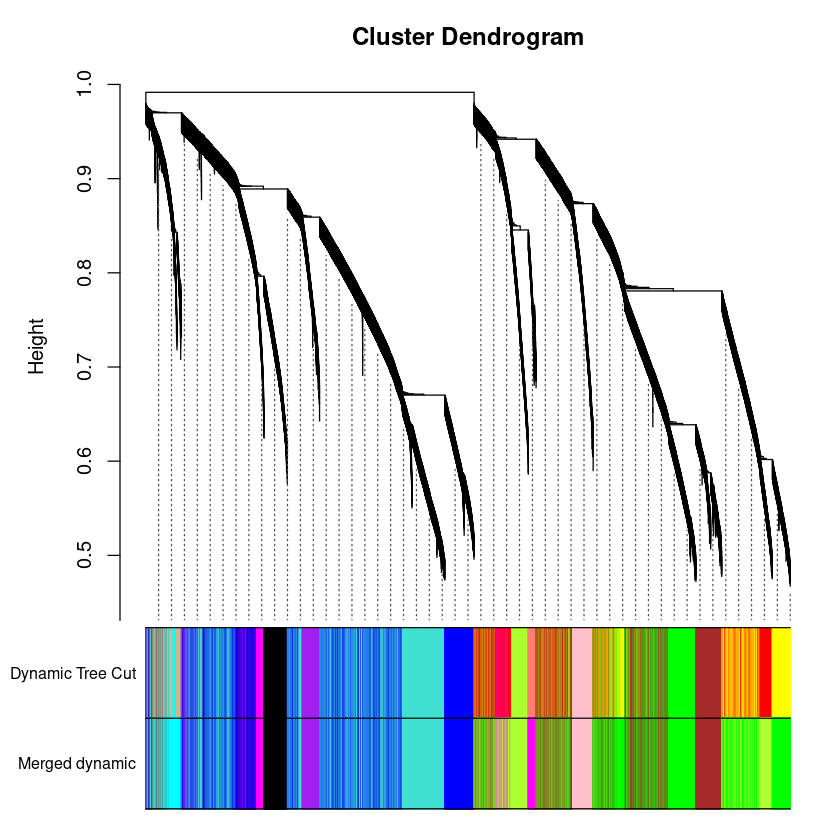

In [29]:
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors), 
                    c("Dynamic Tree Cut", "Merged dynamic"), dendroLabels = FALSE, 
                    hang = 0.04, addGuide = TRUE, guideHang = 0.05)  

In [30]:
# Plot merged module tree
pdf(file = paste0(plots,"/5-merged_Module_Tree.pdf"), width = 12, height = 9)  
plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors), 
                    c("Dynamic Tree Cut", "Merged dynamic"), dendroLabels = FALSE, 
                    hang = 0.03, addGuide = TRUE, guideHang = 0.05)  
dev.off()


pdf 
  2

In [31]:
#save old modules (antes del merge) y su relacion con las muestras (57 modulos) 
write.table(merge$oldMEs,file=paste0(tables,"/oldMEs.txt"),sep ='\t')

#save new modules (despues del merge) y su relacion con las muestras  (19 modulos)
write.table(merge$newMEs,file=paste0(tables,"/newMEs.txt"), sep='\t')

In [32]:
#  Export of networks to external software
# Export the gene list of old modules 
for (i in 1:length(merge$oldMEs)){
  modules = c(substring(names(merge$oldMEs)[i], 3));
  genes = colnames(datExpr)
  inModule = is.finite(match(dynamicColors,modules))
  modGenes = genes[inModule]
  modTOM=TOM[inModule,inModule]
  dimnames(modTOM)=list(modGenes,modGenes)
  cyt = exportNetworkToCytoscape(modTOM,
                                 edgeFile = paste("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA/tables/old_modules/orign_CytoscapeInput-edges-", paste(modules, collapse="-"), ".txt", sep=""),
                                 nodeFile = paste("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA//tables/old_modules/orign_CytoscapeInput-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
                                 weighted = TRUE, threshold = -1, nodeNames = modGenes, nodeAttr = dynamicColors[inModule]);
}

In [33]:
# Export the gene list of new modules 
for (i in 1:length(merge$newMEs)){
  modules = c(substring(names(merge$newMEs)[i], 3));
  genes = colnames(datExpr)
  inModule = is.finite(match(dynamicColors,modules))
  modGenes = genes[inModule]
  modTOM=TOM[inModule,inModule]
  dimnames(modTOM)=list(modGenes,modGenes)
  cyt = exportNetworkToCytoscape(modTOM,
                                 edgeFile = paste("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA/tables/new_modules/merge_CytoscapeInput-edges-", paste(modules, collapse="-"), ".txt", sep=""),
                                 nodeFile = paste("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA/tables/new_modules/merge_CytoscapeInput-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
                                 weighted = TRUE, threshold = -1, nodeNames = modGenes, nodeAttr = dynamicColors[inModule]);
}


In [34]:
#  PART 1: Correlate module eigen-genes and samples (or other discrete data)
# Heatmap of old module eigen-genes and samples
#pdf(file="oldMEs.pdf",heigh=80,width=20)

rownames(merge$oldMEs)=names(tmm_norm[,-181])


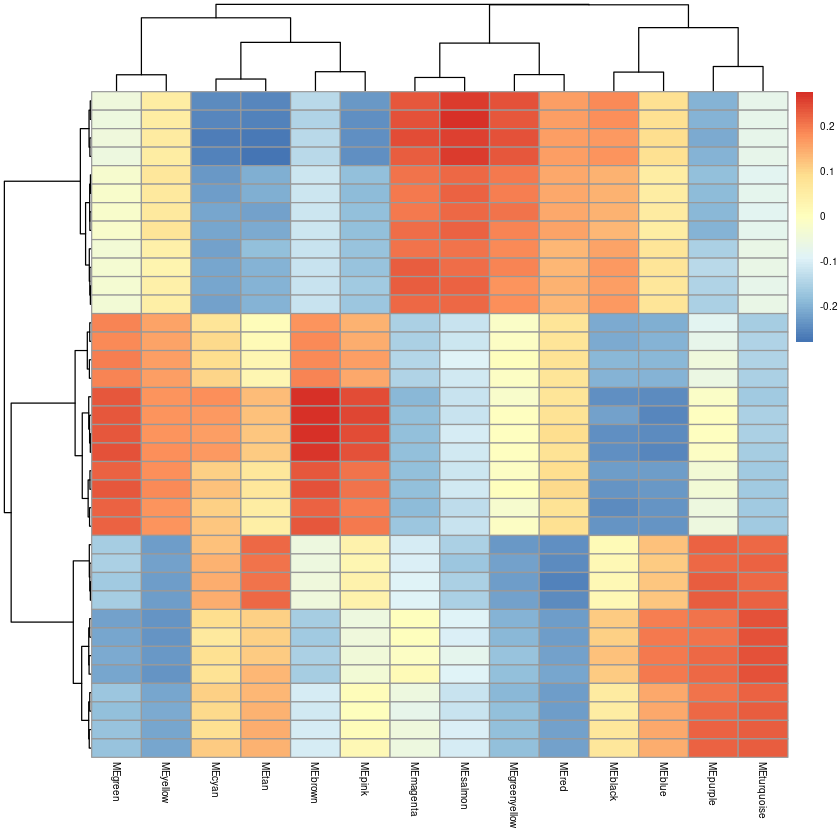

In [35]:
pheatmap(merge$oldMEs,cluster_col=T,cluster_row=T,show_rownames=F,show_colnames=T,fontsize=6)


pdf 
  3

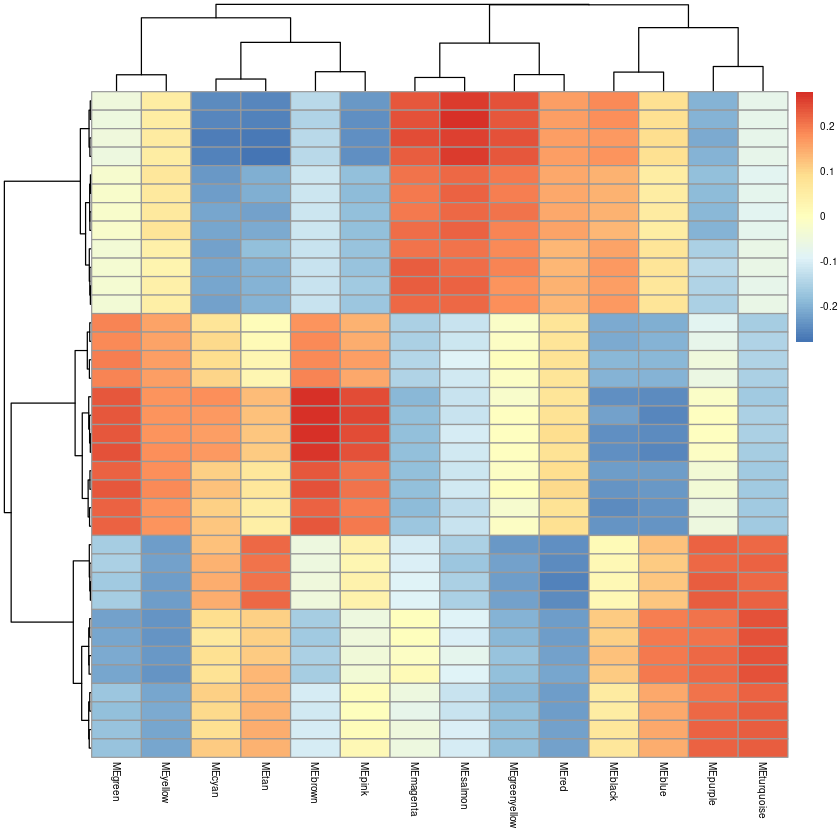

In [36]:
pdf(file=paste0(plots,"/6-oldMEs_heatmap.pdf"),heigh=80,width=20)
pheatmap(merge$oldMEs,cluster_col=T,cluster_row=T,show_rownames=F,show_colnames=T,fontsize=6)
dev.off()


In [37]:
# Heatmap of new module eigen-genes and sample trait (e.g. Zone)
col_ann <- sample_metadata[,c(1,2)]

In [38]:
rownames(col_ann) <- col_ann[,1]

In [39]:
col_ann <- data.frame(col_ann)

In [40]:
col_ann$class <- as.factor(col_ann$class)


In [41]:
col_ann <- col_ann[order(col_ann$class),]


In [42]:
col_ann$sample <- NULL


In [43]:
col_ann

,class
,<fct>
SRR7945375,amastigote
SRR7945376,amastigote
SRR7945377,amastigote
SRR7945378,amastigote
SRR7945379,amastigote
SRR7945380,amastigote
SRR7945393,amastigote
SRR7945394,amastigote
SRR7945395,amastigote


In [44]:
ann_colors = list(
  class = c(amastigote="#440154", metacyclic_promastigote="#21918c",procyclic_promastigote="#fde725"))

In [45]:
data <- data.frame(merge$newMEs)
data <- data[order(match(rownames(data), rownames(col_ann))),]


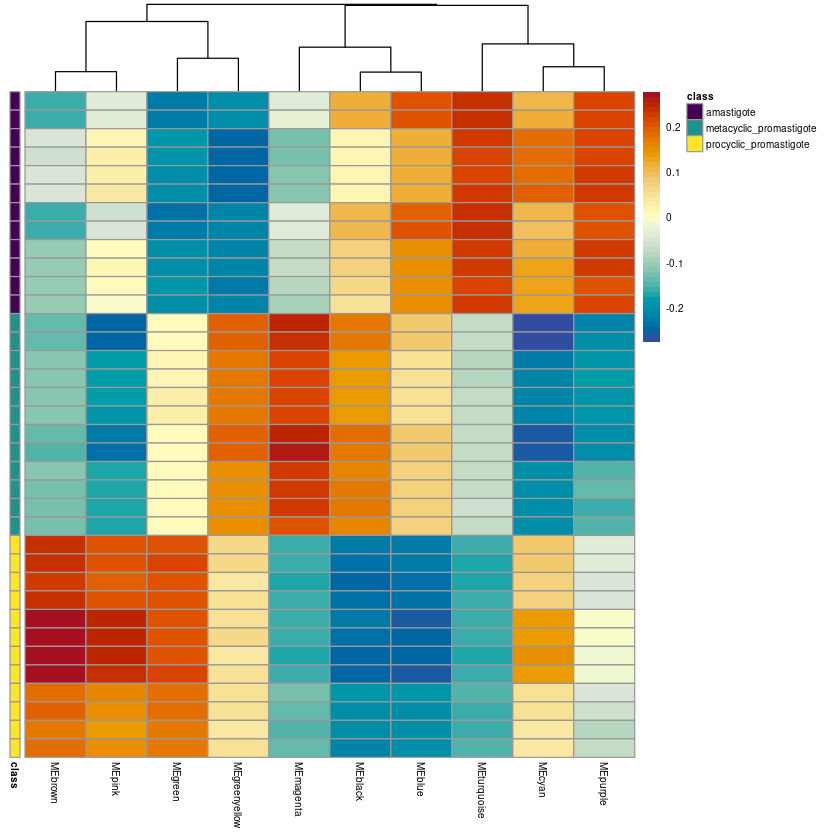

In [46]:
rownames(merge$newMEs)=names(tmm_norm[,-181])
pheatmap(data,
         color = hcl.colors(50, "RdYlBu",rev = T),
         cluster_col=T,
         cluster_row=F,
         show_rownames=F,
         show_colnames=T,
         fontsize=6,
         annotation_row = col_ann, 
         annotation_colors = ann_colors)

pdf 
  3

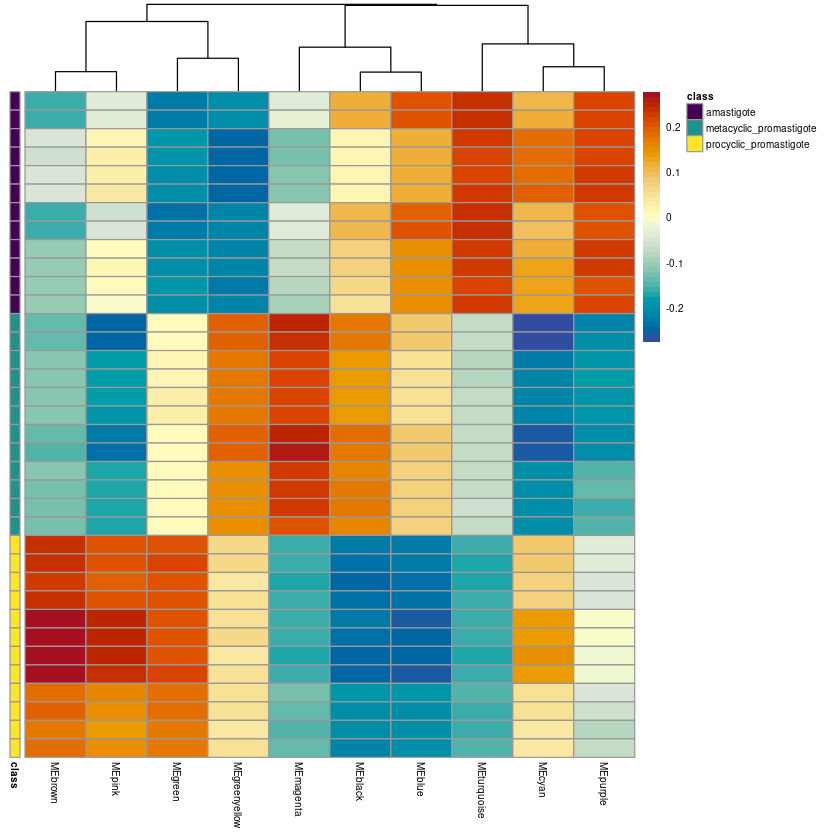

In [47]:
pdf(file=paste0(plots,"/7-newMEs_heatmap.pdf"),heigh=80,width=20)
pheatmap(data,
         color = hcl.colors(50, "RdYlBu",rev = T),
         cluster_col=T,
         cluster_row=F,
         show_rownames=F,
         show_colnames=T,
         fontsize=6,
         annotation_row = col_ann, 
         annotation_colors = ann_colors)
dev.off()

In [48]:
#rownames(traits)<-rownames(MEs)
#load binary trait table 
# debe tener los mismos rownames de MEs
traits<-read.delim("/media/eduardo/D1/ncRNAs_Leishmania_spp/RNAseq/Lbraziliensis/analysis/06_WGCNA/metadata_wgcna.txt",header = TRUE,row.names = 1)

In [49]:
# Define numbers of genes and samples
nGenes = ncol(datExpr);
nSamples = nrow(datExpr);

In [50]:
# Recalculate MEs with color labels
MEs0 = moduleEigengenes(datExpr, mergedColors)$eigengenes
MEs = orderMEs(MEs0)

In [51]:
# Calculate pearson correlation coefficients between module eigen-genes and traits
moduleTraitCor = cor(MEs, traits, use = "p");
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples);

In [52]:
#  Plot heatmap of module-traits relationship
sizeGrWindow(6,10)
# Will display correlations and their p-values
textMatrix =  paste(signif(moduleTraitCor, 2), "\n(",
                    signif(moduleTraitPvalue, 1), ")", sep = "");
dim(textMatrix) = dim(moduleTraitCor)
pdf(paste0(plots,"/8-module-traits.pdf"), width = 20, height = 15,)
par(mar = c(15, 12, 5, 5));
# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = colnames(traits),
               yLabels = colnames(MEs),
               ySymbols = colnames(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 1.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))
dev.off()

png 
  2

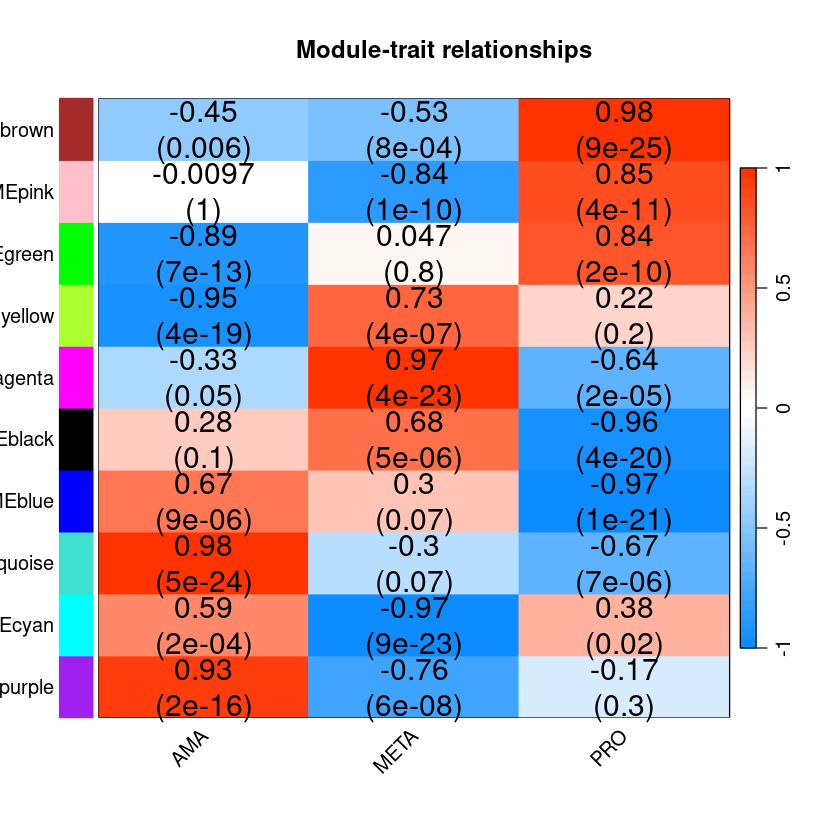

In [53]:

# Display the correlation values within a heatmap plot
labeledHeatmap(Matrix = moduleTraitCor,
               xLabels = colnames(traits),
               yLabels = colnames(MEs),
               ySymbols = colnames(MEs),
               colorLabels = FALSE,
               colors = blueWhiteRed(50),
               textMatrix = textMatrix,
               setStdMargins = FALSE,
               cex.text = 1.5,
               zlim = c(-1,1),
               main = paste("Module-trait relationships"))

In [54]:
# visualize module-trait association as a heatmap

heatmap.data <- merge(MEs, traits, by = 'row.names')

head(heatmap.data)


,Row.names,MEbrown,MEpink,MEgreen,MEgreenyellow,MEmagenta,MEblack,MEblue,MEturquoise,MEcyan,MEpurple,AMA,META,PRO
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,SRR7945367,-0.1395208,-0.2433168,0.006563226,0.1900548,0.2535909,0.1692196,0.08838588,-0.06991473,-0.2712274,-0.2112789,0,1,0
2,SRR7945368,-0.1388180,-0.2453250,0.002905554,0.1905199,0.2437504,0.1733641,0.08613848,-0.06821405,-0.2746391,-0.1993593,0,1,0
3,SRR7945369,-0.1160216,-0.1801252,0.022911939,0.1727395,0.2119800,0.1434648,0.05572836,-0.07945526,-0.2206151,-0.1903271,0,1,0
4,SRR7945370,-0.1122205,-0.1839730,0.022940450,0.1725188,0.2147309,0.1421270,0.05034507,-0.08211146,-0.2175748,-0.1831870,0,1,0
5,SRR7945371,-0.1164410,-0.1832700,0.028502748,0.1716059,0.2193207,0.1355691,0.05287861,-0.07450170,-0.2144778,-0.1957062,0,1,0
6,SRR7945372,-0.1139579,-0.1864381,0.025299311,0.1712928,0.2136994,0.1430640,0.05450545,-0.07332800,-0.2161330,-0.1873422,0,1,0


In [55]:
moduleTraitPvalue

,AMA,META,PRO
MEbrown,6.457776e-03,8.269256e-04,8.799856e-25
MEpink,9.552855e-01,1.209734e-10,4.458451e-11
MEgreen,7.022225e-13,7.857584e-01,1.675584e-10
MEgreenyellow,3.710301e-19,4.165095e-07,1.934973e-01
MEmagenta,4.947641e-02,4.028091e-23,2.367010e-05
MEblack,1.025981e-01,4.557886e-06,3.558662e-20
MEblue,9.474838e-06,7.438040e-02,1.122448e-21
MEturquoise,4.603859e-24,7.325925e-02,6.675207e-06
MEcyan,1.532847e-04,8.787576e-23,2.169808e-02
MEpurple,2.049857e-16,5.915587e-08,3.311452e-01


In [56]:
resdata <- merge(as.data.frame(moduleTraitCor), 
                 as.data.frame(moduleTraitPvalue), 
                 by = 'row.names', sort = FALSE)

In [57]:
resdata

Row.names,AMA.x,META.x,PRO.x,AMA.y,META.y,PRO.y
<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MEbrown,-0.445600260,-0.53256368,0.9781639,6.457776e-03,8.269256e-04,8.799856e-25
MEpink,-0.009686761,-0.84216828,0.8518550,9.552855e-01,1.209734e-10,4.458451e-11
MEgreen,-0.885794982,0.04693524,0.8388597,7.022225e-13,7.857584e-01,1.675584e-10
MEgreenyellow,-0.952679477,0.73084533,0.2218341,3.710301e-19,4.165095e-07,1.934973e-01
MEmagenta,-0.329823800,0.97258764,-0.6427638,4.947641e-02,4.028091e-23,2.367010e-05
MEblack,0.276488952,0.68240207,-0.9588910,1.025981e-01,4.557886e-06,3.558662e-20
MEblue,0.665510400,0.30106025,-0.9665707,9.474838e-06,7.438040e-02,1.122448e-21
MEturquoise,0.975907171,-0.30217699,-0.6737302,4.603859e-24,7.325925e-02,6.675207e-06
MEcyan,0.589815008,-0.97128366,0.3814687,1.532847e-04,8.787576e-23,2.169808e-02


In [58]:
write.table(resdata,file = paste0(tables,"/ModuleTraitCorrelation.tsv"),
            sep = "\t", row.names = F)


In [59]:
amastigote=as.data.frame(traits$AMA)
names(amastigote) = "Amastigote"

In [60]:
metacyclic=as.data.frame(traits$META)
names(metacyclic) = "Metacyclic"

In [61]:
procyclic=as.data.frame(traits$PRO)
names(procyclic) = "Procyclic"

In [62]:
# names (colors) of the modules
modNames = substring(names(MEs), 3)
geneModuleMembership = as.data.frame(cor(datExpr, MEs, use = "p"))
MMPvalue = as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples))
names(geneModuleMembership) = paste("MM", modNames, sep="");
names(MMPvalue) = paste("p.MM", modNames, sep="");

In [63]:
#gene significance para cada tratamiento de interes (eg resistencia)
geneTraitSignificance_amastigote = as.data.frame(cor(datExpr,amastigote, use = "p"))
GSPvalue_amastigote= as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance_amastigote), nSamples))
names(geneTraitSignificance_amastigote) = paste("GS.", names(amastigote), sep="")
names(GSPvalue_amastigote) = paste("p.GS.", names(amastigote), sep="")

In [64]:
geneTraitSignificance_metacyclic = as.data.frame(cor(datExpr,metacyclic, use = "p"))
GSPvalue_metacyclic= as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance_metacyclic), nSamples))
names(geneTraitSignificance_metacyclic) = paste("GS.", names(metacyclic), sep="")
names(GSPvalue_metacyclic) = paste("p.GS.", names(metacyclic), sep="")

In [65]:
geneTraitSignificance_procyclic = as.data.frame(cor(datExpr,procyclic, use = "p"))
GSPvalue_procyclic= as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance_procyclic), nSamples))
names(geneTraitSignificance_procyclic) = paste("GS.", names(procyclic), sep="")
names(GSPvalue_procyclic) = paste("p.GS.", names(procyclic), sep="")

In [66]:
write.table(x = geneModuleMembership,file = paste0(tables,"/geneModuleMembership.csv"), sep = '\t')
write.table(x = MMPvalue,file = paste0(tables,"/PvaluegeneModuleMembership.csv"), sep = '\t')

In [67]:
write.table(x = geneTraitSignificance_amastigote,file = paste0(tables,"/geneTraitSignificance_amastigote.csv"), sep = '\t')
write.table(x = GSPvalue_amastigote,file = paste0(tables,"/GeneSignificancePvalue_amastigote.csv"), sep = '\t')

In [68]:
write.table(x = geneTraitSignificance_metacyclic,file = paste0(tables,"/geneTraitSignificance_metacyclic.csv"), sep = '\t')
write.table(x = GSPvalue_metacyclic,file = paste0(tables,"/GeneSignificancePvalue_metacyclic.csv"), sep = '\t')

In [69]:
write.table(x = geneTraitSignificance_procyclic,file = paste0(tables,"/geneTraitSignificance_procyclic.csv"), sep = '\t')
write.table(x = GSPvalue_procyclic,file = paste0(tables,"/GeneSignificancePvalue_procyclic.csv"), sep = '\t')

In [70]:
MET = orderMEs(cbind(MEs, c(amastigote,metacyclic,procyclic)))


In [71]:
MET

,MEpink,MEbrown,Procyclic,MEgreen,MEgreenyellow,MEcyan,MEpurple,MEturquoise,Amastigote,MEmagenta,Metacyclic,MEblack,MEblue
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>
SRR7945367,-0.2433167964,-0.13952076,0,0.006563226,0.19005479,-0.27122739,-0.211278926,-0.06991473,0,0.25359094,1,0.16921962,0.08838588
SRR7945368,-0.2453249600,-0.13881804,0,0.002905554,0.19051990,-0.27463913,-0.199359272,-0.06821405,0,0.24375037,1,0.17336414,0.08613848
SRR7945369,-0.1801251716,-0.11602156,0,0.022911939,0.17273953,-0.22061507,-0.190327128,-0.07945526,0,0.21197997,1,0.14346477,0.05572836
SRR7945370,-0.1839729663,-0.11222053,0,0.022940450,0.17251882,-0.21757481,-0.183186971,-0.08211146,0,0.21473086,1,0.14212696,0.05034507
SRR7945371,-0.1832699976,-0.11644098,0,0.028502748,0.17160593,-0.21447779,-0.195706229,-0.07450170,0,0.21932071,1,0.13556906,0.05287861
SRR7945372,-0.1864381408,-0.11395787,0,0.025299311,0.17129279,-0.21613305,-0.187342193,-0.07332800,0,0.21369943,1,0.14306398,0.05450545
SRR7945373,0.2065656042,0.23397990,1,0.204668796,0.05785922,0.08335390,-0.037911713,-0.16217738,0,-0.16079208,0,-0.22843578,-0.22539966
SRR7945374,0.2097981567,0.23859690,1,0.212473741,0.06435567,0.08933217,-0.038152567,-0.16439616,0,-0.15553106,0,-0.23781672,-0.23037609
SRR7945375,-0.0427198280,-0.15456375,0,-0.226316836,-0.20803254,0.10361093,0.219067439,0.24102155,1,-0.03415408,0,0.12212264,0.20088914


In [72]:
# Plot the dendrogram
sizeGrWindow(6,6);
pdf(paste0(plots,"/9-module-amastigote.pdf"), width = 20, height = 15,)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
                      plotHeatmaps = FALSE)
# Plot the heatmap matrix (note: this plot will overwrite the dendrogram plot)
par(cex = 1.0)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(10,10,1,2),
                      plotDendrograms = FALSE, xLabelsAngle = 90)
dev.off()

Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”


png 
  2

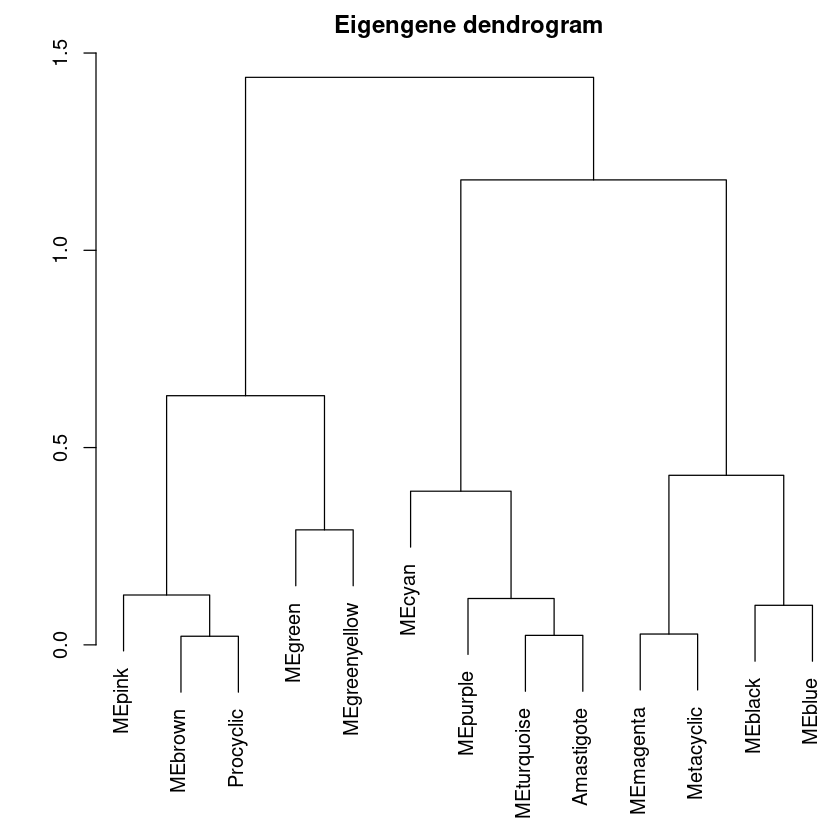

Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”
Warning message in mapply(textFnc, x = labPos$xMid[xTextLabInd], y = xLabYPos, labels = xLabels.show[xTextLabInd], :
“longer argument not a multiple of length of shorter”


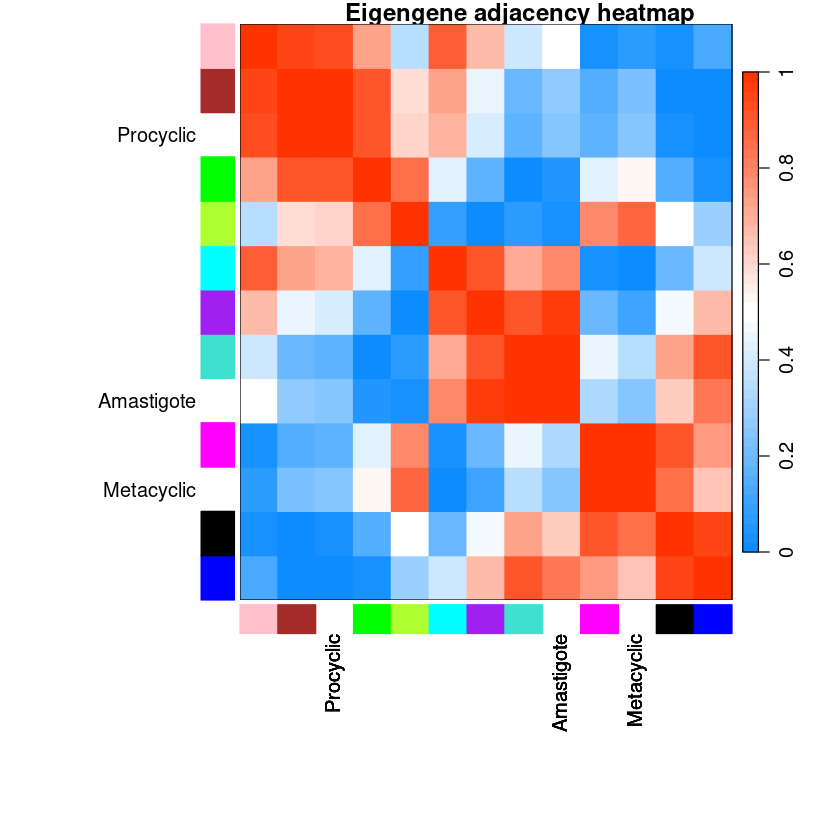

In [73]:
plotEigengeneNetworks(MET, "Eigengene dendrogram", marDendro = c(0,4,2,0),
                      plotHeatmaps = FALSE)
plotEigengeneNetworks(MET, "Eigengene adjacency heatmap", marHeatmap = c(10,10,1,2),
                      plotDendrograms = FALSE, xLabelsAngle = 90)

In [74]:
module = "turquoise"
# Rename to moduleColors
moduleColors = mergedColors
column = match(module, modNames);
moduleGenes = moduleColors==module;
sizeGrWindow(7, 7);
pdf(paste0(plots,"/10-module-amastigote_blue.pdf"), width = 20, height = 15,)
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_amastigote[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for resistance",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "blue")
dev.off()

pdf 
  2

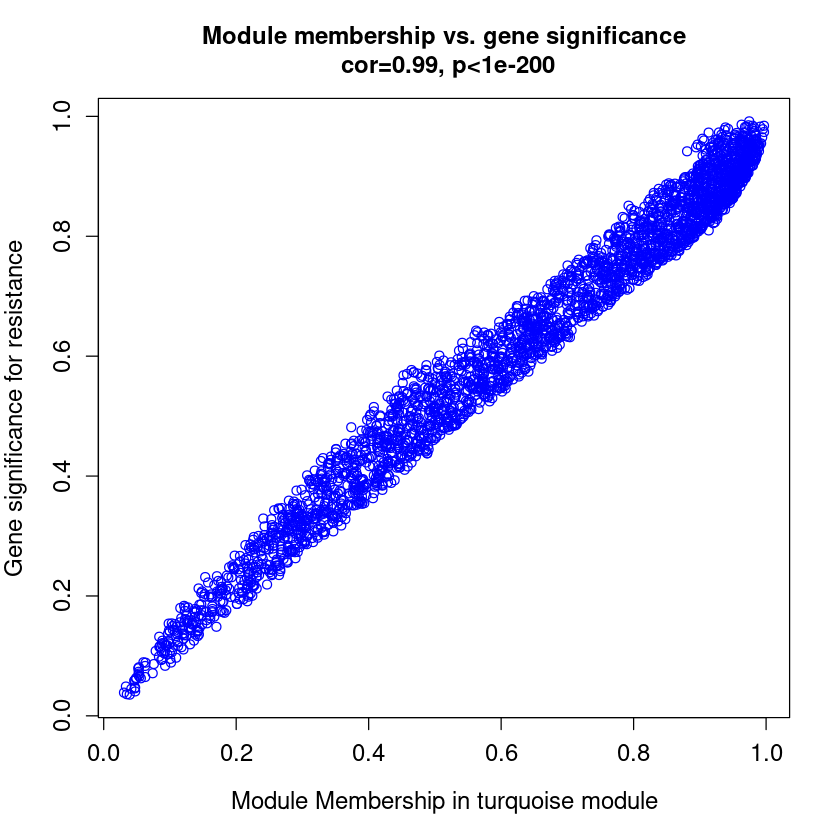

In [75]:
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_amastigote[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for resistance",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "blue")

In [94]:
#Plot correlation membership vs gene significance of a module selected

module = "red"
# Rename to moduleColors
moduleColors = mergedColors
column = match(module, modNames);
moduleGenes = moduleColors==module;
sizeGrWindow(7, 7); 
pdf(paste0(plots,"/12-module-metacyclic_red.pdf"), width = 20, height = 15,)
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_metacyclic[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for non-infected",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "red")
dev.off()

pdf 
  2

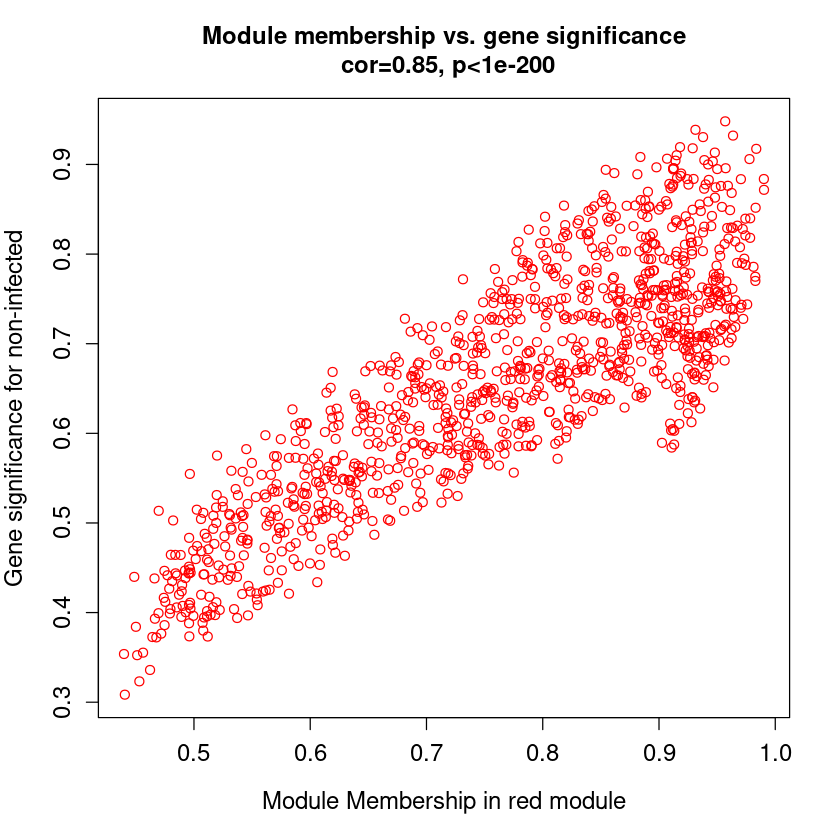

In [95]:
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_metacyclic[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for non-infected",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "red")

In [96]:
#Plot correlation membership vs gene significance of a module selected
module = "brown"
# Rename to moduleColors
moduleColors = mergedColors
column = match(module, modNames);
moduleGenes = moduleColors==module;
sizeGrWindow(7, 7);
pdf(paste0(plots,"/14-module-procyclic_brown.pdf"), width = 20, height = 15,)
par(mfrow = c(1,1));
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_procyclic[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for 24 hpi",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "brown")
dev.off()

pdf 
  2

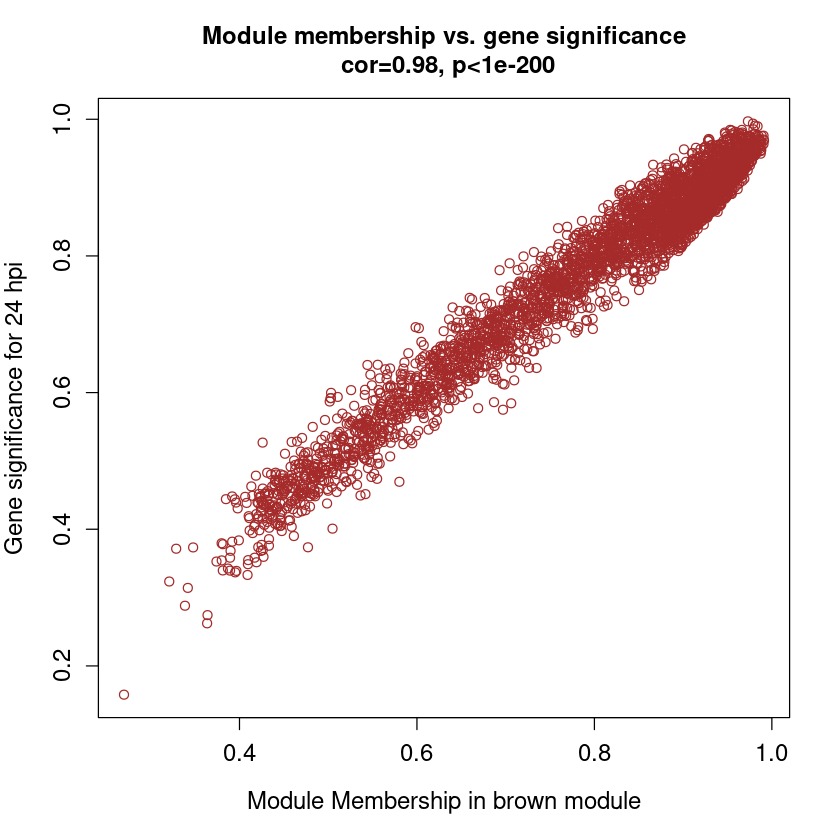

In [97]:
verboseScatterplot(abs(geneModuleMembership[moduleGenes, column]),
                   abs(geneTraitSignificance_procyclic[moduleGenes, 1]),
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for 24 hpi",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = "brown")

In [118]:
#make bignetwork
modules = modNames
inModule = is.finite(match(moduleColors, modules));
modProbes = genes[inModule];
modGenes = genes[inModule]
modTOM = TOM[inModule, inModule];
dimnames(modTOM) = list(modProbes, modProbes)

cyt = exportNetworkToCytoscape(modTOM,
                               edgeFile = paste0(tables,"/bigNet02_edges.txt"),
                               nodeFile =  paste0(tables,"/bigNet02_nodes.txt"),
                               weighted = TRUE,
                               threshold = 0.02,
                               nodeNames = modProbes,
                               altNodeNames = modGenes,
                               nodeAttr = moduleColors[inModule])

In [119]:
save.image(file = "WGCNA_Lbraziliensis.RData")